# Lab07-Image Processing and Analysis

In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from pylab import imread
from skimage.color import rgb2gray

In [2]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00):
    from matplotlib import pyplot as plt
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(nRows, nCols)
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,10))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.subplot(nRows, nCols,i+1)
        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        plt.title("Image " + str(i))
        plt.axis('off')
    plt.show()

In [3]:
def InfoImage(IM):
    Image = IM
    Width = Image.shape[1]
    Height = Image.shape[0]
    Channel = len(Image.shape)
    print("Width : ", Width, " Height : ", Height, " Channel : ", Channel)
    if(Channel == 2):
        print("Min Intensity: ", IM.min(), " Max Intensity: ", IM.max())
    else:
        print("Red - Min Intensity: ", IM[:,:,0].min(), " Max Intensity: ", IM[:,:,0].max())
        print("Green - Min Intensity: ", IM[:,:,1].min(), " Max Intensity: ", IM[:,:,1].max())
        print("Blue - Min Intensity: ", IM[:,:,2].min(), " Max Intensity: ", IM[:,:,2].max())

In [4]:
def ResizeImage(IM, DesiredWidth, DesiredHeight):
    from skimage.transform import rescale, resize
    OrigWidth = float(IM.shape[1])
    OrigHeight = float(IM.shape[0])
    Width = DesiredWidth
    Height = DesiredHeight
    if((Width == 0) & (Height == 0)):
        return IM
    if(Width == 0):
        Width = int((OrigWidth * Height)/OrigHeight)
    if(Height == 0):
        Height = int((OrigHeight * Width)/OrigWidth)
    dim = (Width, Height)
    resizedIM = cv2.resize(IM, dim, interpolation = cv2.INTER_NEAREST)
    return resizedIM

### Dilation

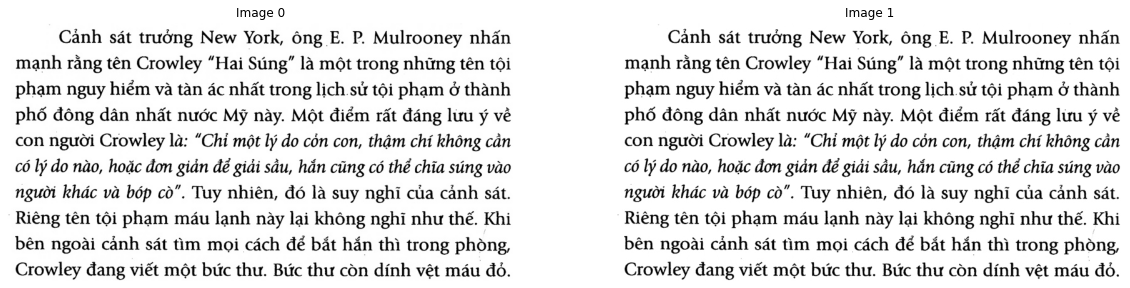

In [5]:
# Read Image
path = "Image/"
image_color = imread(path + "Newspaper.jpg")
# Convert Image into Gray
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
# Display Image
ShowImage([image_color, image_gray], 1, 2)

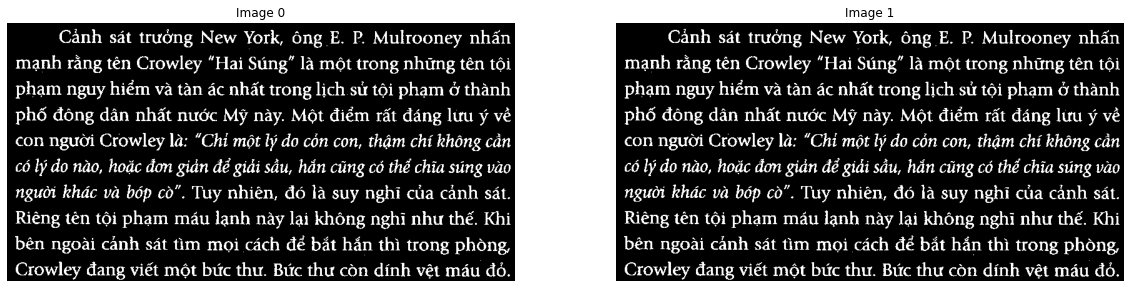

150.0


In [6]:
image_mask01 = (image_gray < 150).astype(np.uint8) * 255 # Change 0-1 to range 0-255
thresh, image_mask02 = cv2.threshold(image_gray,150,255,cv2.THRESH_BINARY_INV)
ShowImage([image_mask01, image_mask02], 1, 2)
print(thresh)

In [7]:
print(image_mask01.min(), image_mask01.max())
print(image_mask02.min(), image_mask02.max())

0 255
0 255


[[1 1 1]
 [1 1 1]
 [1 1 1]]


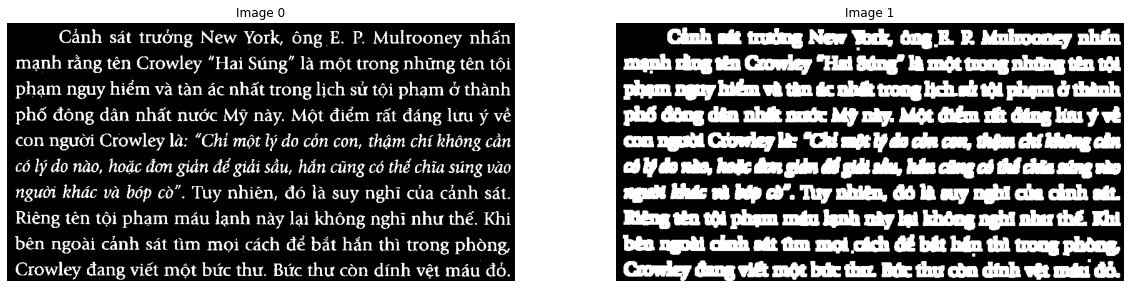

In [8]:
kernel = np.ones((3,3),np.uint8)

print(kernel)
image_dilated = cv2.dilate(image_mask01, kernel, iterations = 2)
ShowImage([image_mask01, image_dilated], 1, 2)

In [9]:
result = image_color.copy()

contours, hierarchy = cv2.findContours(image_dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
count = 0
DataDF = pd.DataFrame(columns = ["x", "y", "w", "h"])
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if(w * h > 300):
        cv2.rectangle(result,(x,y),(x+w,y+h),(0,255,0),2)
        DataDF.loc[count,:] = (x,y,w,h)
        count = count + 1
DataDF = DataDF.astype(int)

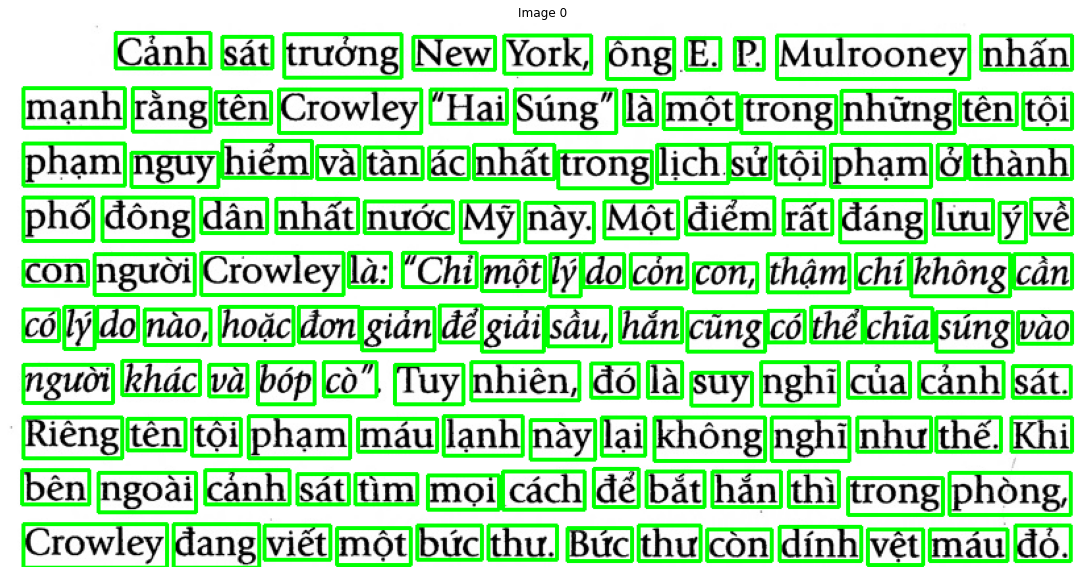

x    y   w   h
0  700  384  59  24
1  653  384  42  27
2  531  384  49  24
3  425  383  49  25
4  250  383  56  28

In [10]:
ShowImage([result], 1, 1)
display(DataDF.head())

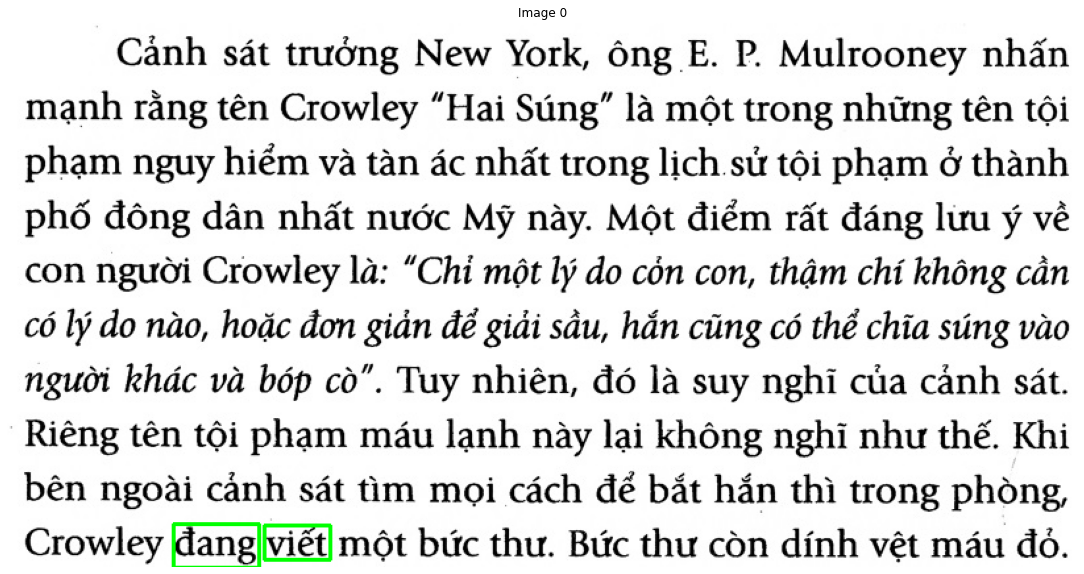

In [11]:
result01 = image_color.copy()

idx = 10
x,y,w,h = DataDF.loc[idx, ["x", "y", "w", "h"]]
cv2.rectangle(result01,(x,y),(x+w,y+h),(0,255,0),2)
idx = 11
x,y,w,h = DataDF.loc[idx, ["x", "y", "w", "h"]]
cv2.rectangle(result01,(x,y),(x+w,y+h),(0,255,0),2)
ShowImage([result01], 1, 1)

### Erison

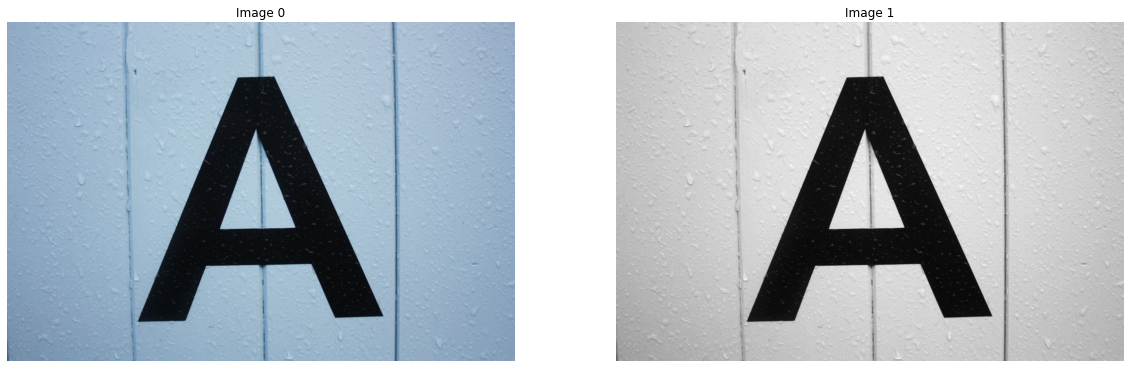

In [12]:
# Read Image

path = "Image/"
image_color = imread(path + "Alphabet.jpg")
# Convert Image into Gray
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
# Display Image
ShowImage([image_color, image_gray], 1, 2)

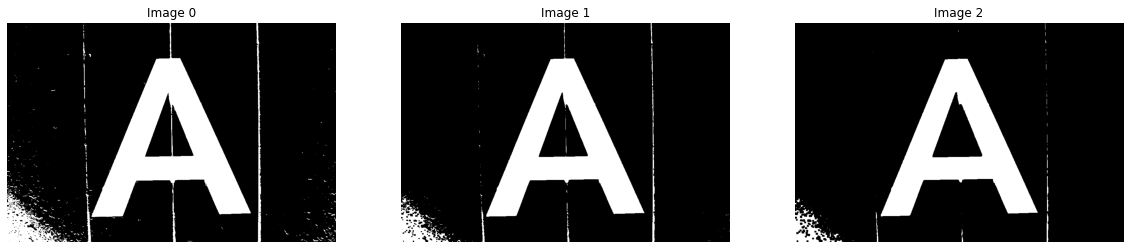

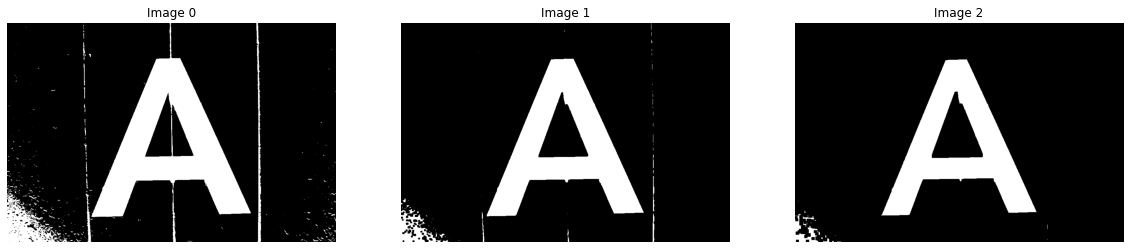

In [13]:
thresh, image_mask = cv2.threshold(image_gray,150,255,cv2.THRESH_BINARY_INV)

kernel = np.ones((3,3),np.uint8)
image_erosion01 = cv2.erode(image_mask,kernel,iterations = 1)
image_erosion02 = cv2.erode(image_mask,kernel,iterations = 2)
kernel = np.ones((5,5),np.uint8)
image_erosion03 = cv2.erode(image_mask,kernel,iterations = 1)
image_erosion04 = cv2.erode(image_mask,kernel,iterations = 2)
ShowImage([image_mask, image_erosion01, image_erosion02], 1, 3)
ShowImage([image_mask, image_erosion03, image_erosion04], 1, 3)

In [14]:
from skimage.measure import label, regionprops

image_mask = image_erosion04.copy()
image_label = label(image_mask) # Label each area in the image from 1 to n
print("index of each region from 1 to ", image_label.max())

index of each region from 1 to  18


In [15]:
regions = regionprops(image_label, intensity_image=image_gray, coordinates='rc')

ColList = ["label", "at_row", "at_col",
"area", "minr", "minc", "maxr", "maxc", "width", "height",
"max_intensity", "mean_intensity", "min_intensity",]
LabelDF = pd.DataFrame(columns = ColList)
for props in regions:
    RowList = []
    label = props.label
    if("label" in ColList):
        RowList.append(label)
    at_row, at_col = props.centroid
    if("at_row" in ColList):
        RowList.append(at_row)
    if("at_col" in ColList):
        RowList.append(at_col)
    if("area" in ColList):
        RowList.append(props.area)
    minr, minc, maxr, maxc = props.bbox
    if("minr" in ColList):
        RowList.append(minr)
    if("minc" in ColList):
        RowList.append(minc)
    if("maxr" in ColList):
        RowList.append(maxr)
    if("maxc" in ColList):
        RowList.append(maxc)
    if("width" in ColList):
        RowList.append(maxc - minc)
    if("height" in ColList):
        RowList.append(maxr - minr)
    if("max_intensity" in ColList):
        RowList.append(props.max_intensity)
    if("mean_intensity" in ColList):
        RowList.append(props.mean_intensity)
    if("min_intensity" in ColList):
        RowList.append(props.min_intensity)
    LabelDF.loc[label-1, 0 : len(RowList)] = RowList

<ipython-input-15-1f0636319164>:1: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  regions = regionprops(image_label, intensity_image=image_gray, coordinates='rc')
<ipython-input-15-1f0636319164>:38: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  LabelDF.loc[label-1, 0 : len(RowList)] = RowList


In [16]:
display(LabelDF.head())

label   at_row   at_col   area minr minc maxr maxc width height  \
0     1  376.752  495.778  81672  111  263  587  734   471    476   
1     2      542      9.5      2  542    9  543   11     2      1   
2     3    574.8     29.8     15  572   29  578   32     3      6   
3     4  639.522  28.3013   2058  581    0  667   76    76     86   
4     5  593.913  40.4162    173  585   24  603   58    34     18   

  max_intensity mean_intensity min_intensity  
0           126        15.5623             3  
1           148            147           146  
2           149        147.733           146  
3           149        137.601            76  
4           149        145.642           141

In [17]:
LabelDF = LabelDF.sort_values(by = "area", ascending = False)

LabelDF = LabelDF.reset_index(drop = True)
LabelDF.head()

label   at_row   at_col   area minr minc maxr maxc width height  \
0     1  376.752  495.778  81672  111  263  587  734   471    476   
1     4  639.522  28.3013   2058  581    0  667   76    76     86   
2     5  593.913  40.4162    173  585   24  603   58    34     18   
3    15  662.557  97.4432     88  656   86  667  104    18     11   
4     7  613.061  30.2449     49  607   25  620   37    12     13   

  max_intensity mean_intensity min_intensity  
0           126        15.5623             3  
1           149        137.601            76  
2           149        145.642           141  
3           148         145.33           138  
4           146        142.735           139

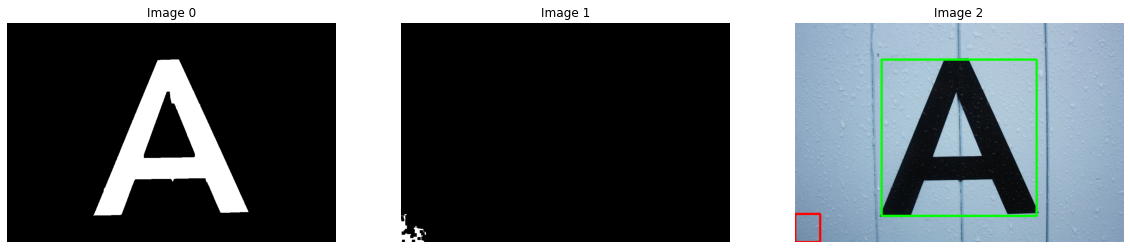

In [18]:
label01 = LabelDF.loc[0, "label"]
label02 = LabelDF.loc[1, "label"]
image_mask_area01 = image_label == label01
image_mask_area02 = image_label == label02
result = image_color.copy()
x = int(LabelDF.loc[0, "minc"])
y = int(LabelDF.loc[0, "minr"])
w = int(LabelDF.loc[0, "width"])
h = int(LabelDF.loc[0, "height"])
cv2.rectangle(result,(x,y),(x+w,y+h),(0,255,0),5)

x = int(LabelDF.loc[1, "minc"])
y = int(LabelDF.loc[1, "minr"])
w = int(LabelDF.loc[1, "width"])
h = int(LabelDF.loc[1, "height"])
cv2.rectangle(result,(x,y),(x+w,y+h),(255,0,0),5)
ShowImage([image_mask_area01, image_mask_area02, result], 1, 3)

### Closing

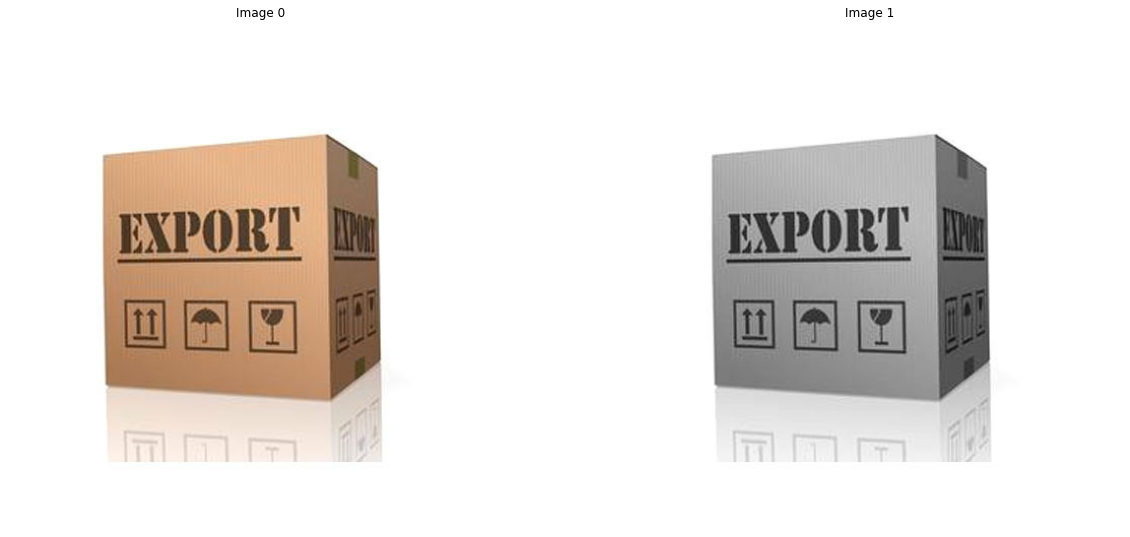

In [19]:
# Read Image

path = "Image/"
image_color = imread(path + "Carton Box.jpg")
# Convert Image into Gray
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
# Display Image
ShowImage([image_color, image_gray], 1, 2)

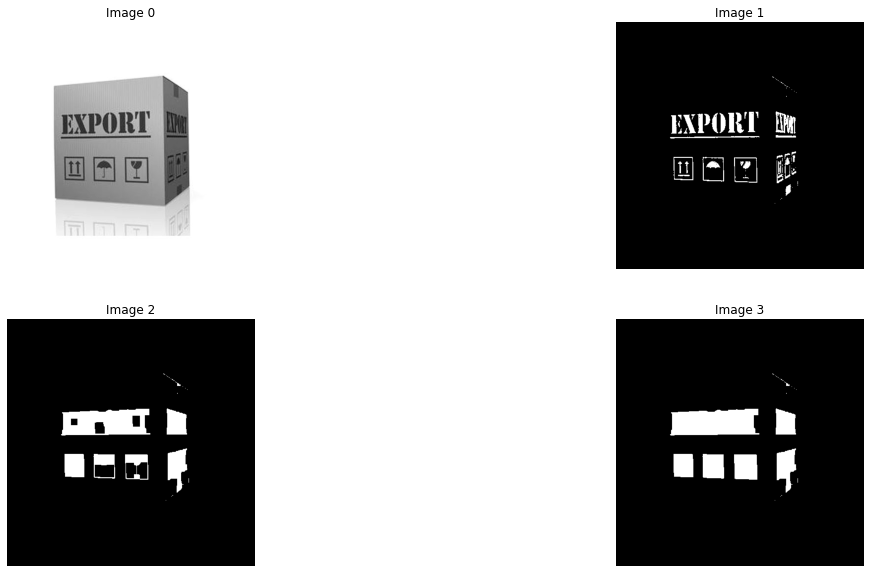

In [20]:
thresh, image_mask = cv2.threshold(image_gray,80,255,cv2.THRESH_BINARY_INV)

image_closing = cv2.morphologyEx(image_mask, cv2.MORPH_CLOSE, kernel,iterations = 3)
from scipy import ndimage as ndi
image_fill = ndi.binary_fill_holes(image_closing)
ShowImage([image_gray, image_mask, image_closing, image_fill], 2, 2)

In [21]:
from skimage.measure import label, regionprops

image_label = label(image_fill) # Label each area in the image from 1 to n
print("index of each region from 1 to ", image_label.max())

index of each region from 1 to  21


In [22]:
regions = regionprops(image_label, intensity_image=image_gray, coordinates='rc')

ColList = ["label", "at_row", "at_col",
"area", "minr", "minc", "maxr", "maxc", "width", "height",
"max_intensity", "mean_intensity", "min_intensity",]
LabelDF = pd.DataFrame(columns = ColList)
for props in regions:
    RowList = []
    label = props.label
    if("label" in ColList):
        RowList.append(label)
    at_row, at_col = props.centroid
    if("at_row" in ColList):
        RowList.append(at_row)
    if("at_col" in ColList):
        RowList.append(at_col)
    if("area" in ColList):
        RowList.append(props.area)
    minr, minc, maxr, maxc = props.bbox
    if("minr" in ColList):
        RowList.append(minr)
    if("minc" in ColList):
        RowList.append(minc)
    if("maxr" in ColList):
        RowList.append(maxr)
    if("maxc" in ColList):
        RowList.append(maxc)
    if("width" in ColList):
        RowList.append(maxc - minc)
    if("height" in ColList):
        RowList.append(maxr - minr)
    if("max_intensity" in ColList):
        RowList.append(props.max_intensity)
    if("mean_intensity" in ColList):
        RowList.append(props.mean_intensity)
    if("min_intensity" in ColList):
        RowList.append(props.min_intensity)
    LabelDF.loc[label-1, 0 : len(RowList)] = RowList

<ipython-input-22-1f0636319164>:1: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  regions = regionprops(image_label, intensity_image=image_gray, coordinates='rc')
<ipython-input-22-1f0636319164>:38: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  LabelDF.loc[label-1, 0 : len(RowList)] = RowList


In [23]:
display(LabelDF.head())

label at_row at_col area minr minc maxr maxc width height max_intensity  \
0     1  112.8  316.4    5  112  315  115  319     4      3            78   
1     2    116    321    1  116  321  117  322     1      1            77   
2     3  117.5  323.5    2  117  323  119  325     2      2            74   
3     4  119.5  326.5    2  119  326  121  328     2      2            79   
4     5    122    330    1  122  330  123  331     1      1            77   

  mean_intensity min_intensity  
0             76            73  
1             77            77  
2             74            74  
3           78.5            78  
4             77            77

label   at_row   at_col  area minr minc maxr maxc width height  \
11    12  211.149  340.704  1817  182  322  235  363    41     53   
12    13  210.561  197.936  8259  183  109  237  289   180     54   
13    14  298.906  342.135  2194  263  324  352  364    40     89   
14    15  296.858  135.567  1847  274  116  321  156    40     47   
15    16  298.491  195.776  2043  274  174  324  218    44     50   
16    17  299.684  261.229  2311  275  238  326  285    47     51   

   max_intensity mean_intensity min_intensity  
11           133        73.4172            15  
12           213        113.539            32  
13           123        81.5137            23  
14           174        114.315            35  
15           175        121.731            42  
16           188        130.193            44

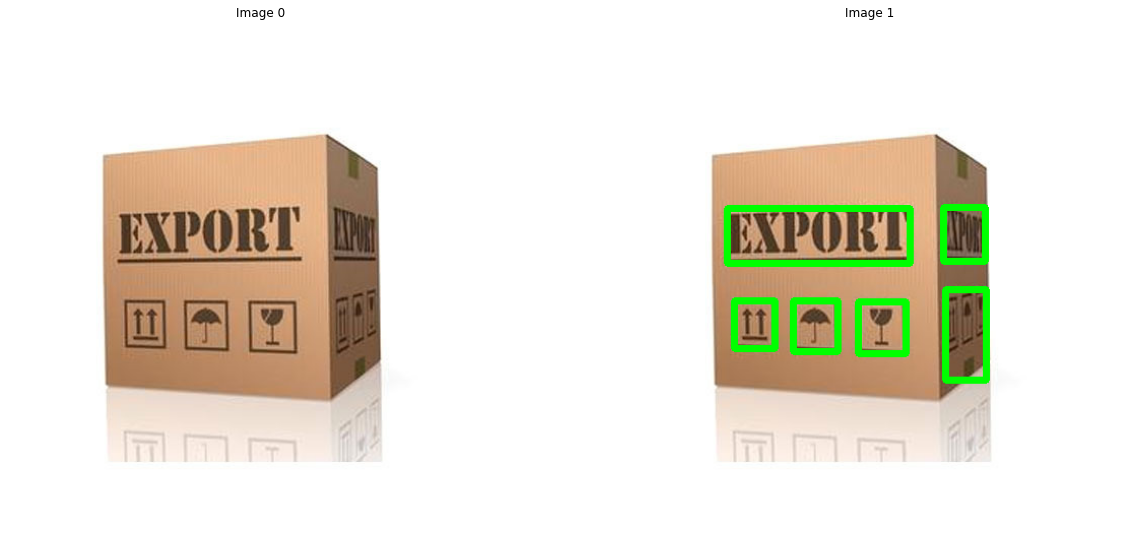

In [24]:
FindDF = LabelDF[LabelDF["area"] > 50]

display(FindDF)
result = image_color.copy()
for idx in FindDF.index:
    x = int(FindDF.loc[idx, "minc"])
    y = int(FindDF.loc[idx, "minr"])
    w = int(FindDF.loc[idx, "width"])
    h = int(FindDF.loc[idx, "height"])
    cv2.rectangle(result,(x,y),(x+w,y+h),(0,255,0),5)
ShowImage([image_color, result], 1, 2)

### Opening

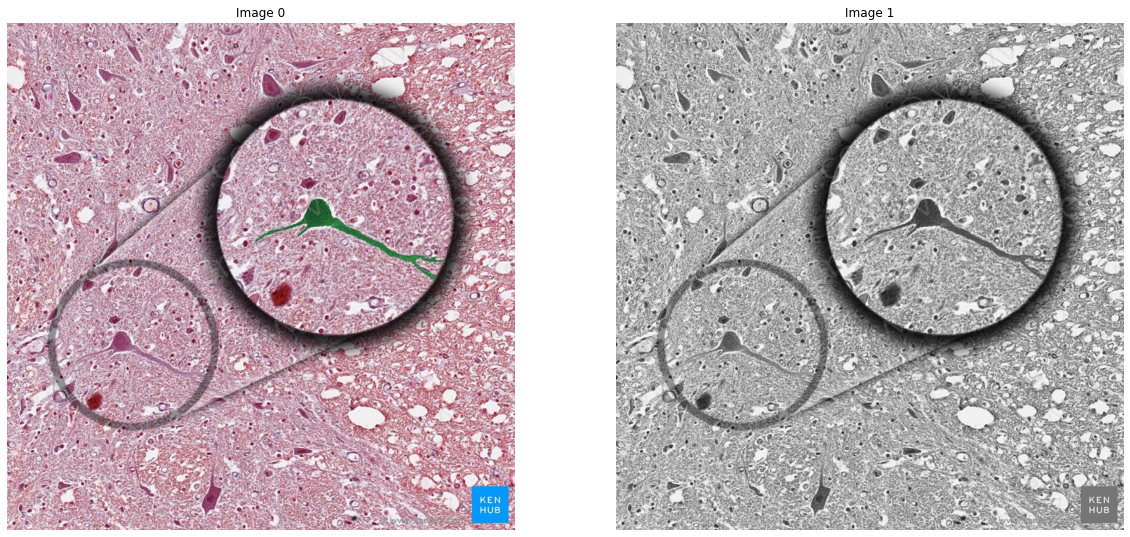

In [25]:
# Read Image

path = "Image/"
image_color = imread(path + "cell.jpg")
# Convert Image into Gray
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
# Display Image
ShowImage([image_color, image_gray], 1, 2)

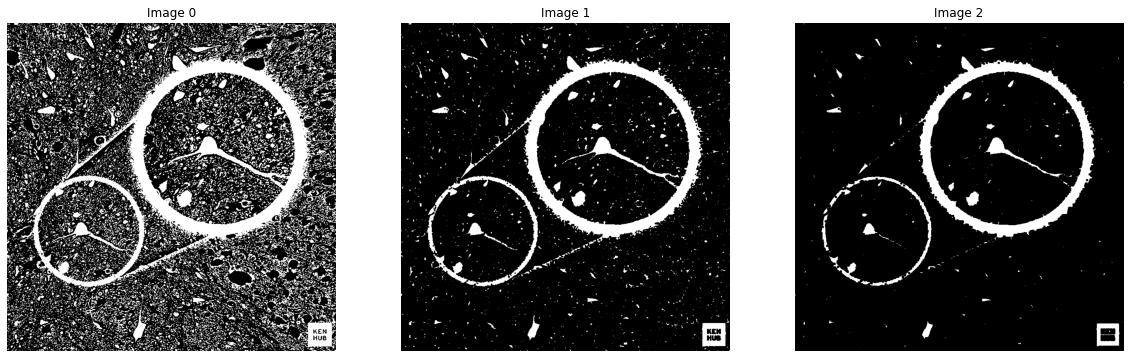

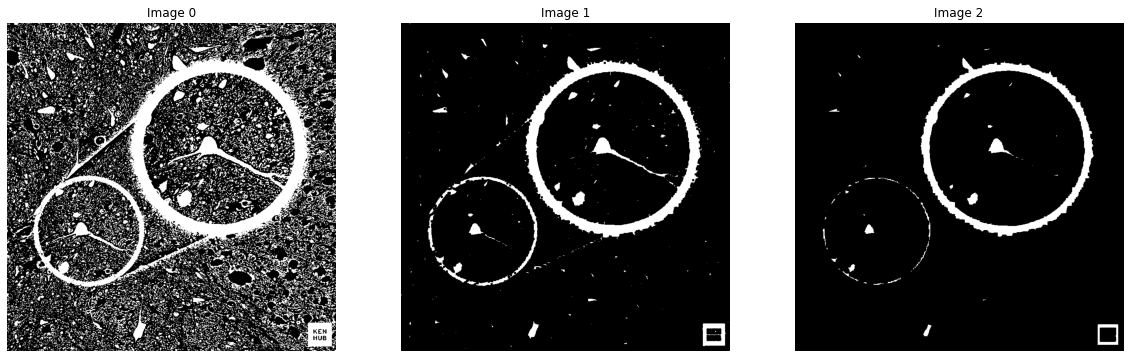

In [26]:
thresh, image_mask = cv2.threshold(image_gray,150,255,cv2.THRESH_BINARY_INV)

kernel = np.ones((3,3),np.uint8)
image_erosion01 = cv2.erode(image_mask,kernel,iterations = 1)
image_erosion02 = cv2.erode(image_mask,kernel,iterations = 2)
kernel = np.ones((5,5),np.uint8)
image_erosion03 = cv2.erode(image_mask,kernel,iterations = 1)
image_erosion04 = cv2.erode(image_mask,kernel,iterations = 2)
ShowImage([image_mask, image_erosion01, image_erosion02], 1, 3)
ShowImage([image_mask, image_erosion03, image_erosion04], 1, 3)

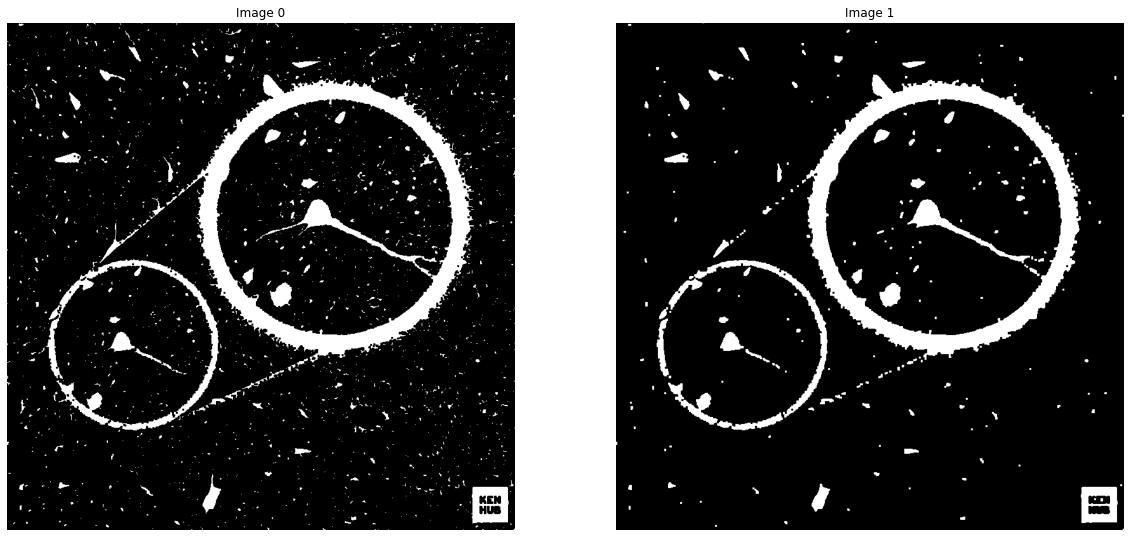

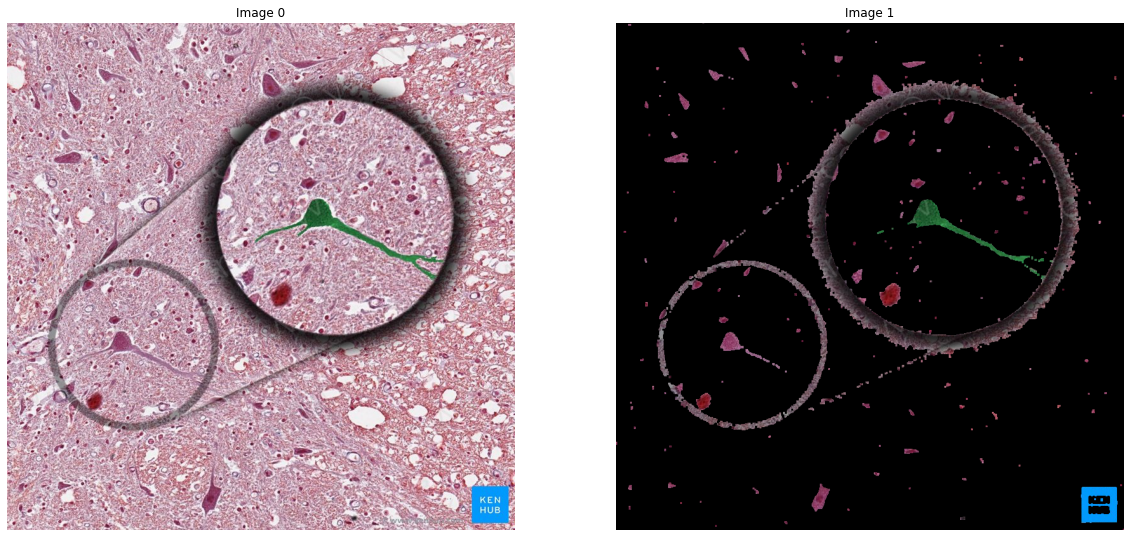

In [27]:
image_mask = image_erosion01.copy()
kernel = np.ones((3,3),np.uint8)
image_opening = cv2.morphologyEx(image_mask, cv2.MORPH_OPEN, kernel)
image_opening_color = cv2.bitwise_and(image_color, image_color, mask = image_opening)
ShowImage([image_mask, image_opening], 1, 2)
ShowImage([image_color, image_opening_color], 1, 2)

### Gradient

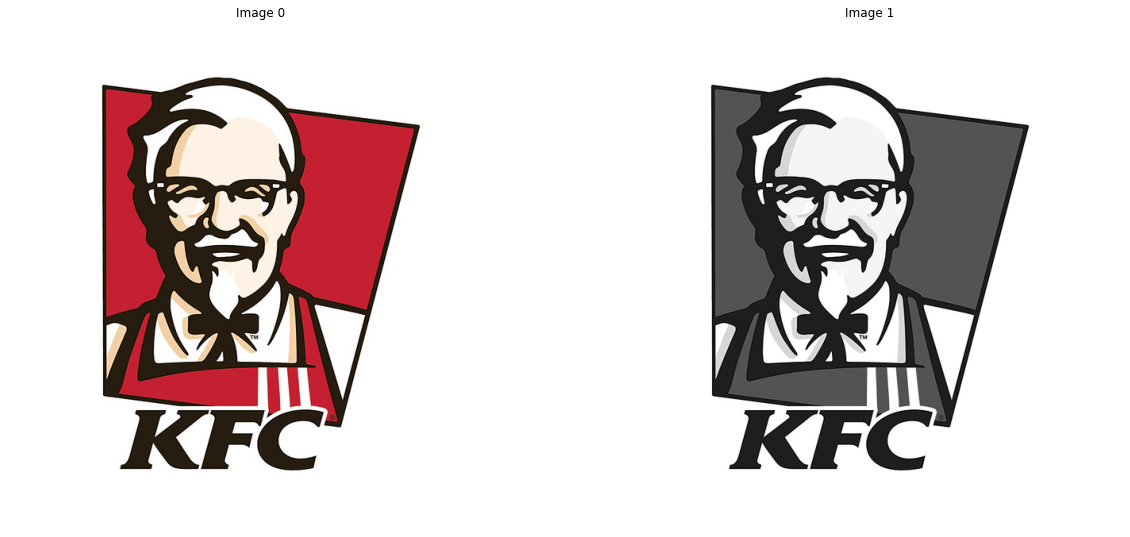

In [28]:
# Read Image

path = "Image/"
image_color = imread(path + "KFC.jpg")
# Convert Image into Gray
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
# Display Image
ShowImage([image_color, image_gray], 1, 2)

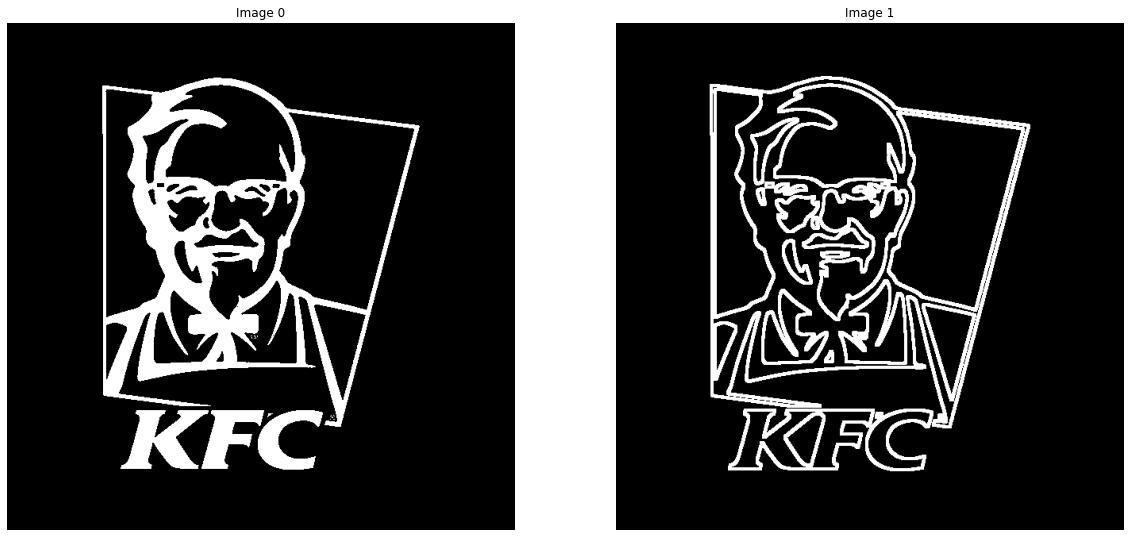

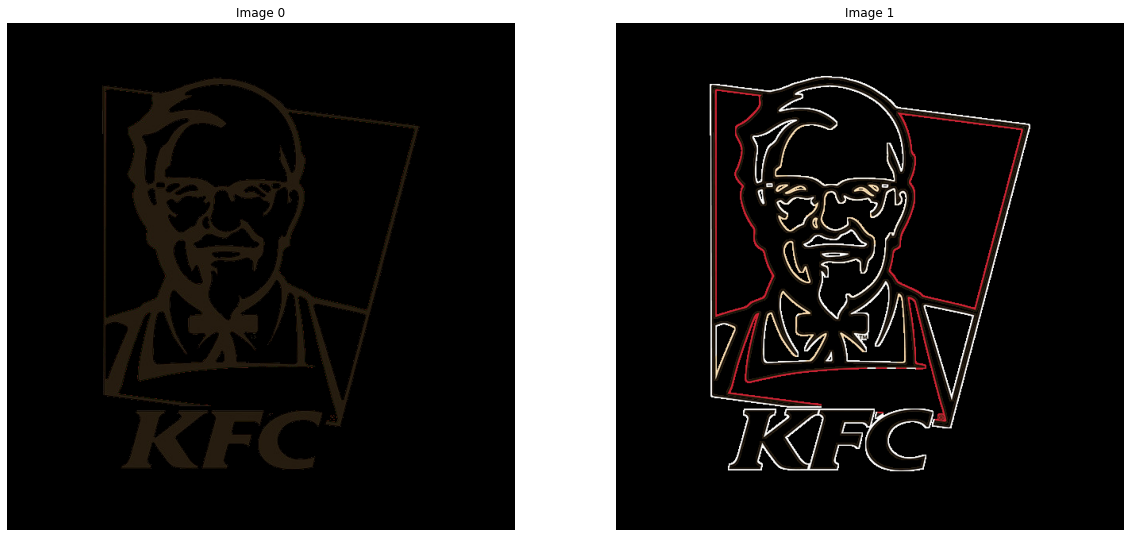

In [29]:
thresh, image_mask = cv2.threshold(image_gray,50,255,cv2.THRESH_BINARY_INV)

kernel = np.ones((5,5),np.uint8)
image_gradient = cv2.morphologyEx(image_mask, cv2.MORPH_GRADIENT, kernel)
image_mask_color = cv2.bitwise_and(image_color, image_color, mask = image_mask)
image_gradient_color = cv2.bitwise_and(image_color, image_color, mask = image_gradient)
ShowImage([image_mask, image_gradient], 1, 2)
ShowImage([image_mask_color, image_gradient_color], 1, 2)

## Kiếm một ảnh biển số xe và thực hiện kết hợp các phương pháp Morphology để trích các con số trên biển số xe 

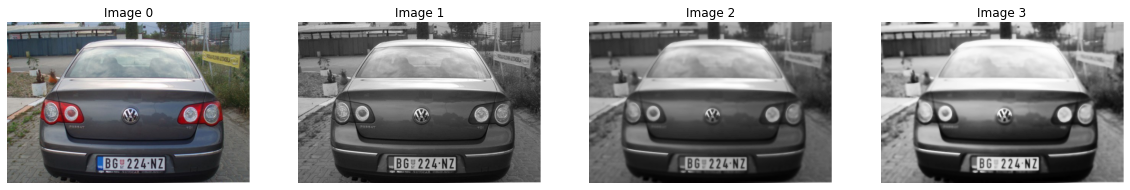

In [78]:
image_color = imread("Image/Car.jpeg")
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)
noise_removal = cv2.bilateralFilter(image_gray,9,75,75)
equal_histogram = cv2.equalizeHist(noise_removal)
# Display Image
ShowImage([image_color, image_gray, noise_removal, equal_histogram],1,4)

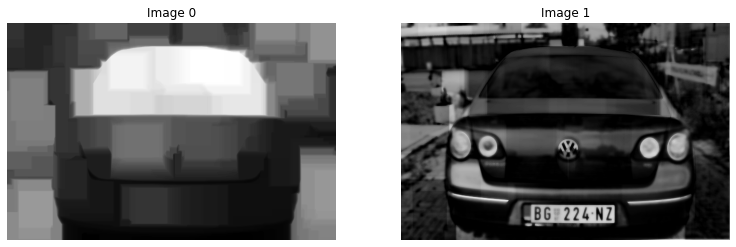

In [79]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))                              
morph_image = cv2.morphologyEx(equal_histogram,cv2.MORPH_OPEN,kernel,iterations=15)
sub_morp_image = cv2.subtract(equal_histogram,morph_image)
ShowImage([morph_image, sub_morp_image], 1, 3)

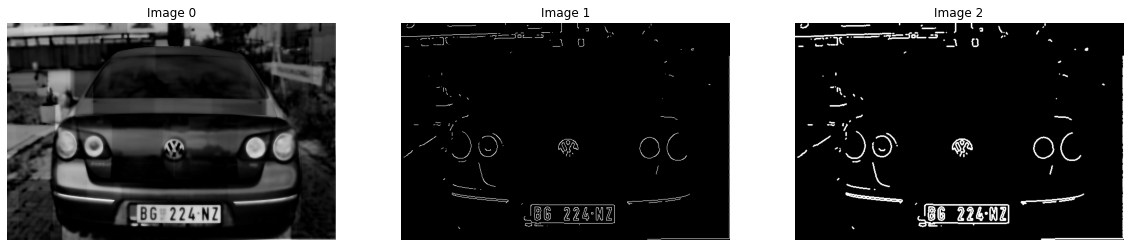

In [90]:
ret,thresh_image = cv2.threshold(sub_morp_image,0,255,cv2.THRESH_TOZERO)
canny_image = cv2.Canny(thresh_image,250,255)
canny_image = cv2.convertScaleAbs(canny_image)
from skimage.morphology import dilation, erosion 
from skimage.morphology import disk
selem = disk(1)
dilated_image = dilation(canny_image, selem) 
ShowImage([thresh_image, canny_image, dilated_image], 1, 3)